# Sentiment analysis using SpaCy

In [76]:
import spacy
from spacy.lang.de.stop_words import STOP_WORDS as STOP_WORDS_DE  #from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS_EN
from spacy.lang.de import German                                  #from spacy.lang.en import English

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
from textblob_de import TextBlobDE as TextBlob                    #from spacytextblob.spacytextblob import SpacyTextBlob as TextBlob
from textblob_de import PatternAnalyzer

import pandas as pd
import string
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [77]:
nlp = spacy.load("de_core_news_lg")
nlp.add_pipe('spacytextblob')
pyLDAvis.enable_notebook()

### Importing data
Import data from a csv file and store it as a dataframe

In [78]:
def get_data(file_name, delimiter, encoding):
    df = pd.read_csv(file_name, encoding=encoding, sep=delimiter)
    df = df.dropna()
    return df

df = get_data('comments_tff-forum-147606.csv', '|', 'utf-8-sig')

### Prepocessing data
Preprocess the data by removing stopwords and punctuation

In [79]:
def preprocess_with_spacy(df_original, column, language):
    if language == 'german':
        stopwords = list(STOP_WORDS_DE)
    else:
        stopwords = list(STOP_WORDS_EN)

    stopwords.extend(['Tesla', 'tesla', 'tesla.com'])
    prefix = ('#','@', 'http')
    
    df = df_original.copy()

    # Remove words with prefixes
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if not word.startswith(prefix)]))
    # Remove stopwords
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stopwords)]))
    # Remove punctuation
    df[column] = df[column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
                                  
    return df

# Utility function for preprocessing tests
def get_merged_text_from_df(df, rows, column_name):
    text = ''
    for i in range(len(df)):
        text += df.loc[i, column_name]
        if i > rows:
            break
            
    return text

spacy_df = preprocess_with_spacy(df, 'post content', 'german')
merged_text = get_merged_text_from_df(spacy_df, 4, 'post content')

In [80]:
# Tokenizer function for dataframe with lemmatization
def tokenize_df_with_spacy(df_spacy, column):
    df = df_spacy.copy()
    
    df[column] = df[column].apply(lambda x: [token.lemma_ for token in nlp(x)])
    df[column] = df[column].apply(lambda x: ' '.join(x))
    
    return df

tokenized_df = tokenize_df_with_spacy(spacy_df, 'post content')
tokenized_df['post content'][0]

'Pilotprojekt starten Niederlanden Webseite Infos füllen -- 1 Nov 21 SuperchargerZugang Fremdmark   Pilotprojekt 213 Start unser Pilotprojekt SuperchargerZugang Fremdmark 10 Standort Niederlanden'

In [81]:
# Tokenizer function for individual sentences
def tokenize_sentence_with_spacy(sentence):
    tokens = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    #tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]

    # Lemmatizing each token
    tokens = [ word.lemma_.strip() for word in tokens ]
    
    # Removing stop words
    tokens = [ word for word in tokens if word not in STOP_WORDS_DE and word not in string.punctuation ]

    # return preprocessed list of tokens
    return tokens

tokenized_sentence = tokenize_sentence_with_spacy(merged_text)

In [ ]:
print(merged_text, '\n', tokenized_sentence)

### Sentiment analysis
Source: 'Sentiment Analysis & Topic Modeling for Hotel Reviews' by Jianmei Wang

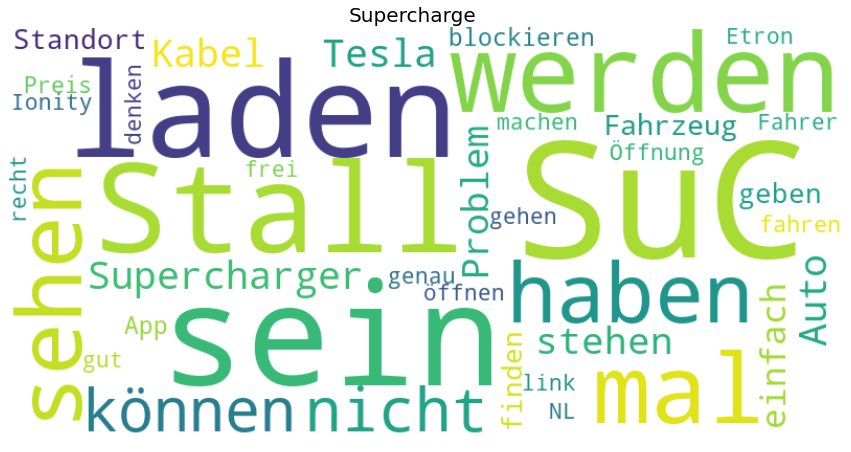

In [83]:
def show_wordcloud(df_tokenized, column_name, color, title):
    '''
    Inputs: 
        df_tokenized - tokenized (and lemmatized) dataframe
        column_name - name of column to be put into wordcloud
        color - background color of worldcloud
        title - title of the wordcloud
    
    Outputs:
        WordCloud displaying the important keywords
            
    '''
    text = df_tokenized[column_name].tolist()
    text_str = ' '.join(text)
    wordcloud = WordCloud(collocations = False, 
                          background_color = color,
                          width=800, 
                          height=400, 
                          margin=2,
                          min_font_size=20).generate(text_str)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    plt.show()
    
show_wordcloud(tokenized_df, 'post content', 'white', 'Supercharge')

/Users/visieu/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2018: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


The shape of the tfidf is (1007, 408), meaning that there are 1007 post content and 408 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Model Log Likelihood Score:  -5161.000890938698
Model Perplexity:  1020.7720034960723


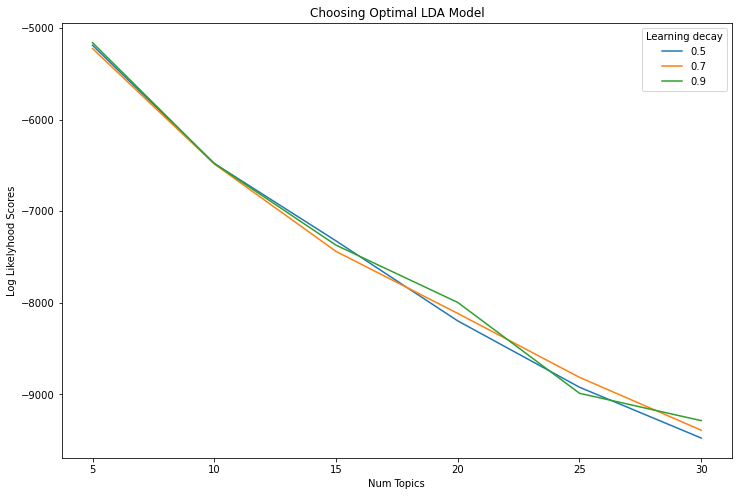

In [84]:
def search_for_best_LDA_model(df_tokenized, column_name):
    '''
    Inputs: 
        df_tokenized - tokenized (and lemmatized) dataframe
        column_name - name of column to be analysed
    
    Outputs:
        lda_tfidf - Latent Dirichlet Allocation (LDA) model
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
        A graph comparing LDA Model Performance Scores with different params
    '''
    
    #************   Step 1: Convert to document-term matrix   ************#
    
    # Initialize the vectorizer
    tf_vectorizer = CountVectorizer(
                        strip_accents = 'unicode',
                        stop_words = 'english',
                        lowercase = True,
                        token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                        max_df = 0.9,                        # discard words that appear in > 90% of the posts
                        min_df = 10                          # discard words that appear in < 10 posts 
                    )                            

    # Create TfidfVectorizer object
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
    
    # Define the corpus and convert it to a document-term matrix
    corpus = df_tokenized[column_name].tolist()
    dtm_tfidf = tfidf_vectorizer.fit_transform(corpus)
    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], column_name, dtm_tfidf.shape[1]))
    
        
    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Define Search Param
    search_params = {'n_components': [5, 10, 15, 20, 25, 30], 
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm_tfidf)

    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))

    
    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelyhoods from Grid Search Output
    gscore=model.fit(dtm_tfidf).cv_results_
    n_topics = [5, 10, 15, 20, 25, 30]

    log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
    log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
    log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return best_lda_model, dtm_tfidf, tfidf_vectorizer

best_lda_model, dtm_tfidf, tfidf_vectorizer = search_for_best_LDA_model(tokenized_df, 'post content')

In [85]:
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), n_top_words = 10) 

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,kabel,18.3,sehen,10.5,suc,23.9,links,12.8,suc,8.8
1,nicht,14.2,mal,9.6,laden,22.4,hinten,12.4,kwh,8.6
2,sein,13.0,werden,9.6,stall,17.1,rechts,12.2,ionity,8.3
3,stall,11.5,sein,9.3,sein,16.6,stall,11.6,kosten,7.3
4,suc,11.1,finden,9.0,werden,16.2,etron,10.3,pro,7.1
5,laden,10.5,eher,9.0,mal,15.7,stecker,9.3,deutschland,6.6
6,lang,9.5,warten,8.9,auto,13.6,seite,8.9,niederlanden,6.2
7,preis,9.2,supercharger,7.0,konnen,12.8,blockieren,8.6,problem,6.1
8,werden,9.0,app,6.9,geben,12.5,stehen,8.5,sein,6.1
9,haben,8.9,danke,6.7,haben,11.8,falsch,8.4,ccs,6.0


In [86]:
# Topic Modelling Visualization for the Negative Reviews
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

/Users/visieu/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/visieu/opt/miniconda3/envs/nlp/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.010773 -0.026882       1        1  32.473029
0      0.026554  0.030245       2        1  23.574604
1      0.099448 -0.111898       3        1  15.843565
4      0.048476  0.131438       4        1  14.842419
3     -0.185250 -0.022904       5        1  13.266384, topic_info=        Term       Freq      Total Category  logprob  loglift
224    links  12.000000  12.000000  Default  30.0000  30.0000
168   hinten  12.000000  12.000000  Default  29.0000  29.0000
308   rechts  12.000000  12.000000  Default  28.0000  28.0000
109    etron  13.000000  13.000000  Default  27.0000  27.0000
341  stecker  10.000000  10.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
144    genau   3.981751  15.773324   Topic5  -4.5765   0.6433
199    laden   4.919346  39.949549   Topic5  -4.3650  -0.0745
264    nicht   4.168164  26.050731   Topic5  -4.5307   0.1874
347      suc   3.758439  47.005683   Topic5  -4.6342  -0.5063
115   fahrer   3.137244  16.683350   Topic5  -4.8149   0.3489

[278 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.084565       abo
1         2  0.591955       abo
1         4  0.338260       abo
5         1  0.723967   aktuell
5         2  0.241322   aktuell
...     ...       ...       ...
395       4  0.225008     woche
396       1  0.441520    wollen
396       2  0.110380    wollen
396       3  0.441520    wollen
405       1  0.759778  zulassen

[534 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

In [87]:
def assess_sentiment(df_tokenized, column):
    df = df_tokenized.copy()
    # Create new column to store sentiment
    df['polarity score'] = ['']*len(df)
    df['subjectivity score'] = ['']*len(df)
    
    for i, row in df.iterrows():
        blob = TextBlob(df.at[i,column])
        
        df.at[i, 'polarity score'] = round(blob.sentiment[0],2)
        df.at[i, 'subjectivity score'] = round(blob.sentiment[1],2)
            
    return df

df_sentiment = assess_sentiment(df, 'post content')
df_sentiment.to_csv('comments_tff-forum-147606_sentiment', encoding='utf-8-sig')

## End

In [54]:
text = "Aber habe ich viel Geld. Schlecte Laune"
doc = TextBlob(text)
doc.words.lemmatize()

WordList(['aber', 'haben', 'ich', 'viel', 'Geld', 'Schlect', 'Laune'])

In [68]:
from textblob_de.lemmatizers import PatternParserLemmatizer
_lemmatizer = PatternParserLemmatizer()
tokens = _lemmatizer.lemmatize(text)
lemmatized_text = ' '.join( [ word[0] for word in tokens ])
print(lemmatized_text)

aber leidern haben ich nur noch Eur 3.50 in mein Brieftasche


In [70]:
from textblob_de import PatternAnalyzer
#text = "Aber leider habe ich nur noch EUR 3.50 in meiner Brieftasche."
text = lemmatized_text
blob = TextBlob(text)
blob.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [ ]:
for sentence in sentences:
    doc = nlp(sentence)
    descriptive_term = ''
    target = ''
    for token in doc:
        if token.pos_ == 'NOUN':
            target = token.text
        if token.pos_ == 'ADJ':
            descriptive_term = token
            
    print(sentence)
    print('aspect:', target, 'description: ', descriptive_term, '\n')
        #print(token.text, token.dep_, token.head.text, token.head.pos_, token.pos_,[child for child in token.children])

Das Pilotprojekt startet jetzt in den Niederlanden
aspect: Pilotprojekt description:   

 Tesla hat seine Webseite mit Infos gefüllt
aspect: Infos description:   

    tesla
aspect:  description:   

com – 1 Nov 21    Supercharger-Zugang für Fremdmarken - Pilotprojekt 213 Start unseres Pilotprojekts mit Supercharger-Zugang für Fremdmarken an 10 Standorten in den Niederlanden
aspect: Standorten description:   


aspect:  description:   

